# 📊 Pneumonia Detection from Chest X-rays using Transfer Learning
**Kaggle Dataset**: [Chest X-ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)

This notebook uses Google Colab with GPU to train a deep learning model that distinguishes between NORMAL and PNEUMONIA X-ray images using transfer learning (ResNet50).

In [ ]:
# 🔧 Install kagglehub
!pip install kagglehub --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)

In [ ]:
# 🔐 Authenticate Kaggle API using kaggle.json
import os, shutil
shutil.move("/content/kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("✅ Kaggle API is now authenticated.")

✅ Kaggle API is now authenticated.


In [ ]:
# 📦 Import and download dataset using kagglehub
import kagglehub
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("✅ Path to dataset files:", path)

✅ Path to dataset files: /kaggle/input/chest-xray-pneumonia


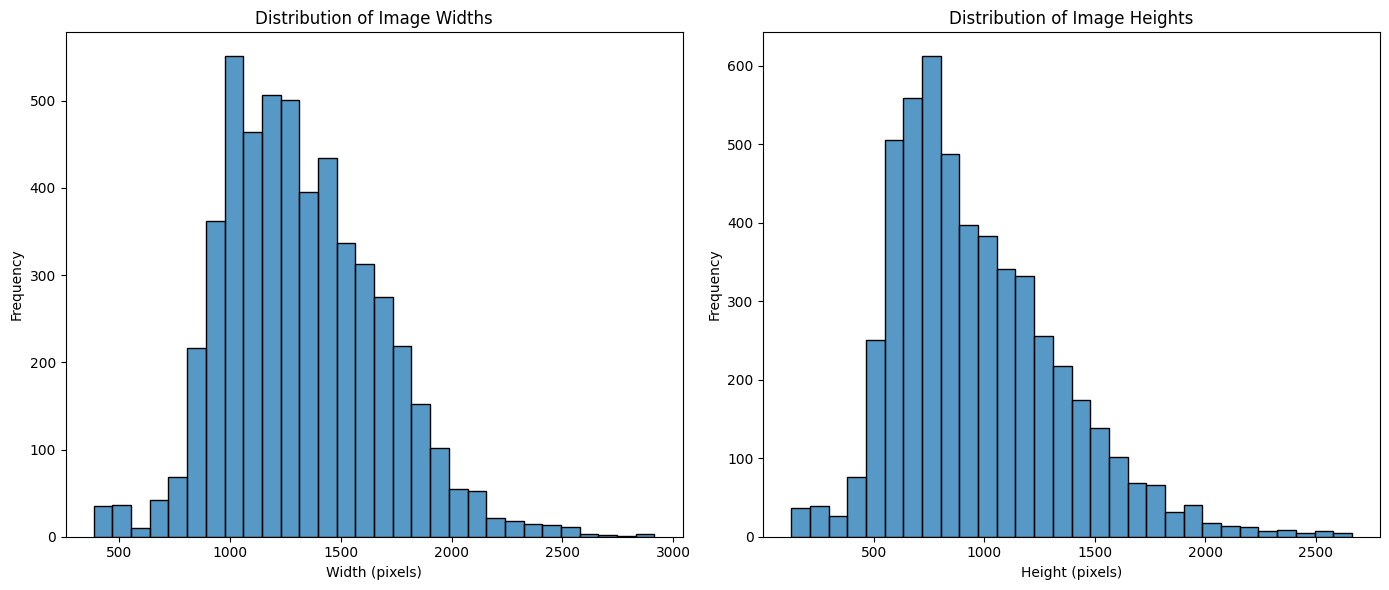

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Set dataset path – adjust to your dataset root
dataset_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'  # Change to /val or /test as needed

# Initialize lists to store image dimensions
widths = []
heights = []

# Loop through subfolders (e.g., NORMAL, PNEUMONIA)
for label in os.listdir(dataset_path):
    label_folder = os.path.join(dataset_path, label)
    if os.path.isdir(label_folder):
        for img_file in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_file)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

# Plot histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(widths, bins=30, kde=False)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=30, kde=False)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter

resolutions = list(zip(widths, heights))
common_resolutions = Counter(resolutions).most_common(10)

print("Top 10 Most Common Image Resolutions:")
for res, count in common_resolutions:
    print(f"{res[0]}x{res[1]}: {count} images")


Top 10 Most Common Image Resolutions:
1072x648: 7 images
1080x728: 6 images
1008x704: 5 images
1008x680: 5 images
976x672: 5 images
1216x872: 5 images
992x592: 5 images
1064x760: 5 images
1024x632: 4 images
1128x752: 4 images


/tmp/ipython-input-3285672005.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='pastel')


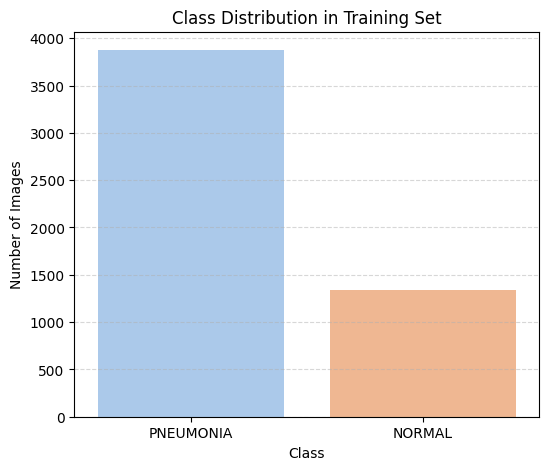

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Path to dataset – change as needed
dataset_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'  # Or 'val', 'test'

# Count images per class
class_counts = {}
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        count = len([f for f in os.listdir(label_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[label] = count

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='pastel')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

TRAIN - NORMAL: 1341 images
TRAIN - PNEUMONIA: 3875 images
VAL - NORMAL: 8 images
VAL - PNEUMONIA: 8 images
TEST - NORMAL: 234 images
TEST - PNEUMONIA: 390 images


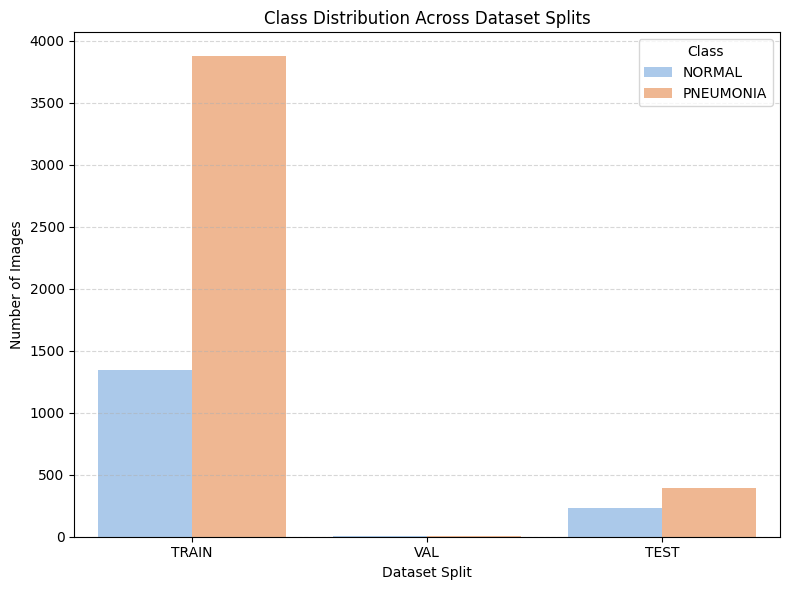

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Base dataset directory
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'  # Update this if your structure is different

# Data splits
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

# Create a dataframe to store counts
data = []

for split in splits:
    split_path = os.path.join(base_dir, split)
    for cls in classes:
        class_path = os.path.join(split_path, cls)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            data.append({'Split': split.upper(), 'Class': cls, 'Count': count})
            print(f"{split.upper()} - {cls}: {count} images")

df = pd.DataFrame(data)

# Plot grouped bar chart
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Split', y='Count', hue='Class', palette='pastel')
plt.title('Class Distribution Across Dataset Splits')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Class')
plt.tight_layout()
plt.show()

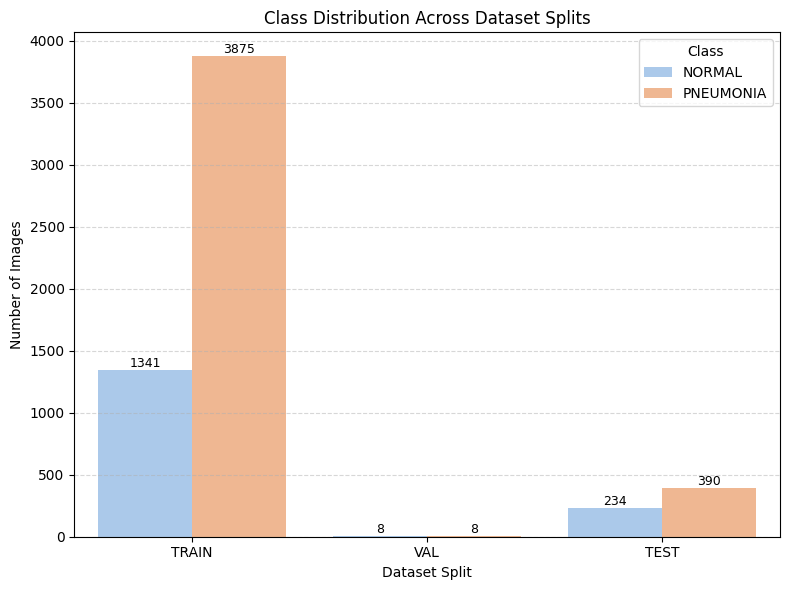

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df, x='Split', y='Count', hue='Class', palette='pastel')
plt.title('Class Distribution Across Dataset Splits')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# Optional: log scale to show tiny bars like val set
# plt.yscale('log')

# Annotate bar values
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

plt.legend(title='Class')
plt.tight_layout()
plt.show()


In [ ]:
# 🧹 Data Preprocessing and Augmentation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = f"{path}/chest_xray/train"
val_path = f"{path}/chest_xray/val"
test_path = f"{path}/chest_xray/test"

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)
val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_path, target_size=(224, 224), class_mode='binary')
val_data = val_test_gen.flow_from_directory(val_path, target_size=(224, 224), class_mode='binary')
test_data = val_test_gen.flow_from_directory(test_path, target_size=(224, 224), class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# 🧠 Build Transfer Learning Model (ResNet50)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# 📈 Train the Model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.7416 - loss: 0.5752

163/163 ━━━━━━━━━━━━━━━━━━━━ 147s 821ms/step - accuracy: 0.7416 - loss: 0.5751 - val_accuracy: 0.5000 - val_loss: 0.7774
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 622ms/step - accuracy: 0.7376 - loss: 0.5417 - val_accuracy: 0.5000 - val_loss: 0.7840
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 633ms/step - accuracy: 0.7511 - loss: 0.5028 - val_accuracy: 0.5000 - val_loss: 0.8134
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7480 - loss: 0.4868

163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 621ms/step - accuracy: 0.7480 - loss: 0.4868 - val_accuracy: 0.5625 - val_loss: 0.7051
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 641ms/step - accuracy: 0.7478 - loss: 0.4772 - val_accuracy: 0.5625 - val_loss: 0.7356
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 623ms/step - accuracy: 0.7726 - loss: 0.4470 - val_accuracy: 0.5625 - val_loss: 0.7571
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 617ms/step - accuracy: 0.7750 - loss: 0.4402 - val_accuracy: 0.5625 - val_loss: 0.7733


In [ ]:
# 📊 Evaluate on Test Set
loss, acc = model.evaluate(test_data)
print(f'Test Accuracy: {acc*100:.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - accuracy: 0.6878 - loss: 0.5680
Test Accuracy: 70.51%


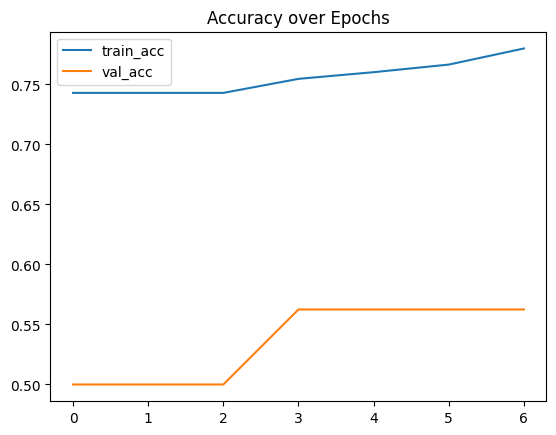

In [ ]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show both plots
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
preds = model.predict(test_data)
y_pred = (preds > 0.5).astype("int32")
y_true = test_data.classes

# Confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=test_data.class_indices.keys())

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", cr)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 634ms/step
Confusion Matrix:
 [[  0 234]
 [  0 390]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
